# Explotratory data analysis (EDA) of the Capstone project

## In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image.
### Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image. While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.
### In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.
### Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.
### Details about the data and dataset files are given in below link,
https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

### Import various packages

In [1]:
#%tensorflow_version 2.x
import tensorflow
tensorflow.__version__
## ignore warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
import pydicom as dcm
from glob import glob
from skimage.transform import resize
from skimage import io, measure
import cv2, random

import tensorflow as tf
from tensorflow import keras

In [2]:
# Initialize the random number generator
import random
random.seed(0)

### Load the dataset and check the number of entries dataframe:

In [3]:
import os 
cwd = os.getcwd()
cwd

'F:\\Vikas\\Great_Learning\\MyProgms\\Capstone'

In [4]:
data_path = cwd + '\\Project_data'
os.chdir(data_path)
os.listdir('.//')

['GCP Credits Request Link - RSNA.txt',
 'stage_2_detailed_class_info.csv',
 'stage_2_sample_submission.csv',
 'stage_2_test_images',
 'stage_2_train_images',
 'stage_2_train_labels.csv']

In [124]:
df = pd.read_csv('stage_2_train_labels.csv')
print('First five rows of Training set:\n', df.head())
print('\nThe train_label dataframe has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
# Number of unique patientId:
print('Number of unique patientId are: {}'.format(df['patientId'].nunique()))
#train_labels= pd.read_csv('stage_2_train_labels.csv')
#print('First five rows of Training set:\n', train_labels.head())
#print('_________________')
#print(train_labels.iloc[0])

First five rows of Training set:
                               patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

The train_label dataframe has 30227 rows and 6 columns.
Number of unique patientId are: 26684


### Sampling the original dataframe (so that we can run our model in short time)

In [125]:
train_labels = df#df.iloc[:15000,:]#df.sample(15000)
print('The train_label dataframe has {} rows and {} columns.'.format(train_labels.shape[0], train_labels.shape[1]))
# Number of unique patientId:
print('Number of unique patientId are: {}'.format(train_labels['patientId'].nunique()))

The train_label dataframe has 30227 rows and 6 columns.
Number of unique patientId are: 26684


### Pie chart for negative and positive targets

No of entries which has Pneumonia: 6012 i.e., 23.0%
No of entries which don't have Pneumonia: 20672 i.e., 77.0%


<AxesSubplot:ylabel='Target'>

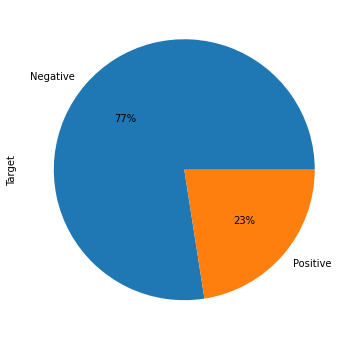

In [126]:
one = train_labels.drop_duplicates('patientId')[train_labels.Target == 1].shape[0]
zero = train_labels.drop_duplicates('patientId')[train_labels.Target == 0].shape[0]
total = train_labels.drop_duplicates('patientId').shape[0]
print(f'No of entries which has Pneumonia: {one} i.e., {round(one/total*100, 0)}%')
print(f'No of entries which don\'t have Pneumonia: {zero} i.e., {round(zero/total*100.0, 0)}%')
train_labels.drop_duplicates('patientId')['Target'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Negative', 'Positive'], figsize = (10, 6))

In [127]:
# Checking nulls in bounding box columns for the whole dataframe and for the patients having pneumonia:
print('Number of nulls in bounding box columns in whole dataframe: {}'.format(train_labels[['x', 'y', 'width', 'height']].isnull().sum().to_dict()))
print('Number of nulls in bounding box columns for patient with pneumonia: {}'.format(train_labels[train_labels.Target == 1][['x', 'y', 'width', 'height']].isnull().sum().to_dict()))

Number of nulls in bounding box columns in whole dataframe: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Number of nulls in bounding box columns for patient with pneumonia: {'x': 0, 'y': 0, 'width': 0, 'height': 0}


In [128]:
train_labels.fillna(0, inplace = True)
print(type(train_labels.iloc[0]['x']))
train_labels.head()

<class 'numpy.float64'>


patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

### Find the number of boxes given for each patient and include that entry in train_label dataframe

In [129]:
bounding_box = train_labels.groupby('patientId').size().to_frame('number_of_boxes').reset_index()
print(bounding_box.head(10))
print(bounding_box.shape)

                              patientId  number_of_boxes
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6                1
1  000924cf-0f8d-42bd-9158-1af53881a557                1
2  000db696-cf54-4385-b10b-6b16fbb3f985                2
3  000fe35a-2649-43d4-b027-e67796d412e0                2
4  001031d9-f904-4a23-b3e5-2c088acd19c6                2
5  0010f549-b242-4e94-87a8-57d79de215fc                1
6  001916b8-3d30-4935-a5d1-8eaddb1646cd                1
7  0022073f-cec8-42ec-ab5f-bc2314649235                2
8  0022995a-45eb-4cfa-9a59-cd15f5196c64                1
9  0025d2de-bd78-4d36-9f72-e15a5e22ca82                1
(26684, 2)


In [130]:
train_labels.head(10)

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
6  00569f44-917d-4c86-a842-81832af98c30    0.0    0.0    0.0     0.0       0
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    0.0    0.0    0.0     0.0       0
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

In [131]:
train_labels.shape

(30227, 6)

### Include the number of boxes as a column in the dataframe 'train_label'

In [132]:
train_labels = train_labels.merge(bounding_box, on = 'patientId', how = 'left')
print(train_labels.head())
print(train_labels.shape)

                              patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes  
0                1  
1                1  
2                1  
3                1  
4                2  
(30227, 7)


In [133]:
#train_labels['Target'==0]['number_of_boxes']=0
train_labels.loc[(train_labels.Target == 0), 'number_of_boxes'] = 0
train_labels.head(20)

patientId      x      y  width  height  Target  \
0   0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1   00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2   00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3   003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   
6   00569f44-917d-4c86-a842-81832af98c30    0.0    0.0    0.0     0.0       0   
7   006cec2e-6ce2-4549-bffa-eadfcd1e9970    0.0    0.0    0.0     0.0       0   
8   00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1   
9   00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1   
10  008c19e8-a820-403a-930a-bc74a4053664    0.0    0.0    0.0     0.0       0   
11  009482dc-3db5-48d4-8580-5c89c4f01334    0.0    0.0    0.0     0.0       0   
12  009eb222-eabc-4150-8121-d5a6d06b8ebf    0.0    0.0    0.0     0.0       0   
13  00a85be6-6eb0-421d-8acf-ff2dc0007e8a    0.0    0.0    0.0     0.0       0   
14  00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0       1   
15  00aecb01-a116-45a2-956c-08d2fa55433f  547.0  299.0  119.0   165.0       1   
16  00c0b293-48e7-4e16-ac76-9269ba535a62  306.0  544.0  168.0   244.0       1   
17  00c0b293-48e7-4e16-ac76-9269ba535a62  650.0  511.0  206.0   284.0       1   
18  00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b    0.0    0.0    0.0     0.0       0   
19  00f08de1-517e-4652-a04f-d1dc9ee48593  181.0  184.0  206.0   506.0       1   

    number_of_boxes  
0                 0  
1                 0  
2                 0  
3                 0  
4                 2  
5                 2  
6                 0  
7                 0  
8                 2  
9                 2  
10                0  
11                0  
12                0  
13                0  
14                2  
15                2  
16                2  
17                2  
18                0  
19                2

In [134]:
train_labels[train_labels.patientId == '00436515-870c-4b36-a041-de91049b9ab4']

patientId      x      y  width  height  Target  \
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   

   number_of_boxes  
4                2  
5                2

In [135]:
#train_labels.loc[0]['number_of_boxes']
#bounding_box['number_of_boxes'].unique()

In [136]:
print('Number of patientIds per bounding box in the dataset: ')
#(bounding_box.groupby('number_of_boxes').size().to_frame('number_of_patientId').reset_index().set_index('number_of_boxes').sort_values(by = 'number_of_boxes'))
(train_labels.groupby('number_of_boxes').size().to_frame('number_of_patientId').reset_index().set_index('number_of_boxes').sort_values(by = 'number_of_boxes'))


Number of patientIds per bounding box in the dataset: 


number_of_patientId
number_of_boxes                     
0                              20672
1                               2614
2                               6532
3                                357
4                                 52

In [137]:
#bounding_box['number_of_boxes'].unique()
#print(bounding_box.groupby('number_of_boxes').groups)#.size().to_frame('number_of_patientId')#.reset_index().set_index('number_of_boxes').sort_values(by = 'number_of_boxes'))

### Read the info about the target class of each patient

In [138]:
df_class_labels = pd.read_csv('stage_2_detailed_class_info.csv')
print('First five rows of Class label dataset are:\n', df_class_labels.head(10))
print('\nThe class_label dataframe has {} rows and {} columns.'.format(df_class_labels.shape[0], df_class_labels.shape[1]))

First five rows of Class label dataset are:
                               patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
6  00569f44-917d-4c86-a842-81832af98c30  No Lung Opacity / Not Normal
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970  No Lung Opacity / Not Normal
8  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity

The class_label dataframe has 30227 rows and 2 columns.


In [139]:
class_labels = df_class_labels#df_class_labels.iloc[:15000,:]
print('The class_label dataframe has {} rows and {} columns.'.format(class_labels.shape[0], class_labels.shape[1]))
print('Number of unique patientId are: {}'.format(class_labels['patientId'].nunique()))

The class_label dataframe has 30227 rows and 2 columns.
Number of unique patientId are: 26684


In [140]:
class_labels

patientId                         class
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2      00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4      00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
...                                     ...                           ...
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8                  Lung Opacity
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba                        Normal
30224  c1f6b555-2eb1-4231-98f6-50a963976431                        Normal
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity

[30227 rows x 2 columns]

### Pie chart for representation for various target values

Percentage of different class representation is as follows:


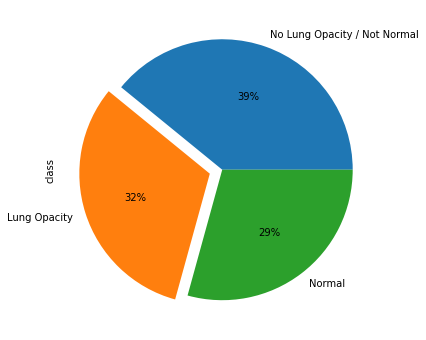

In [141]:
print('Percentage of different class representation is as follows:')
class_labels['class'].value_counts(normalize = True)*100
_ = class_labels['class'].value_counts(normalize = True).plot(kind = 'pie', explode = [0, 0.1, 0], autopct = '%.0f%%', labels = ['No Lung Opacity / Not Normal', 
'Lung Opacity', 'Normal'], figsize = (10, 6))

In [142]:
print('Number of nulls in class columns: {}'.format(class_labels['class'].isnull().sum()))

Number of nulls in class columns: 0


### Checking if any patient id is associated with multiple class

In [143]:
class_labels.groupby(['patientId'])['class'].nunique().max()

1

### Include class labels in train_labels, and create a new dataframe which contains both

In [144]:
print('class label:\n',class_labels.head())
print('\ntrain labels:\n',train_labels.head())
training_data = pd.concat([train_labels, class_labels['class']], axis = 1)
print('\nAfter merging, the dataset looks like: \n')
print(training_data.head())
print('\nAfter merge, the dataset has {} rows and {} columns.'.format(training_data.shape[0], training_data.shape[1]))

class label:
                               patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

train labels:
                               patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes  
0                0  
1                0  
2     

In [145]:
temp = training_data.groupby('Target')['class'].value_counts()
temp

Target  class                       
0       No Lung Opacity / Not Normal    11821
        Normal                           8851
1       Lung Opacity                     9555
Name: class, dtype: int64

In [146]:
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()

In [147]:
data_target_class

Target                         class  Values
0       0  No Lung Opacity / Not Normal   11821
1       0                        Normal    8851
2       1                  Lung Opacity    9555

Text(0.5, 1.0, 'Class and Target for Chest Exams')

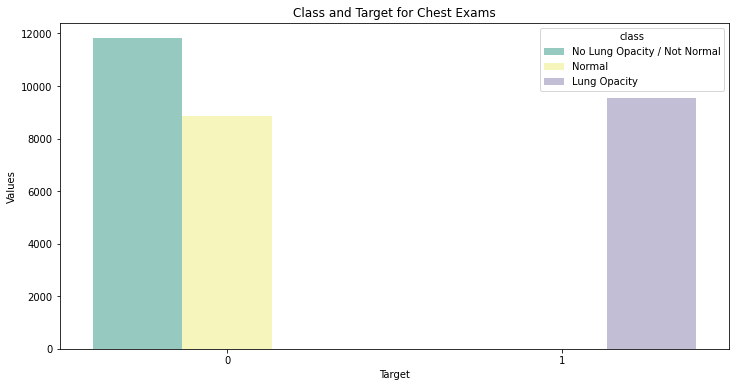

In [148]:
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'Set3')
plt.title('Class and Target for Chest Exams')

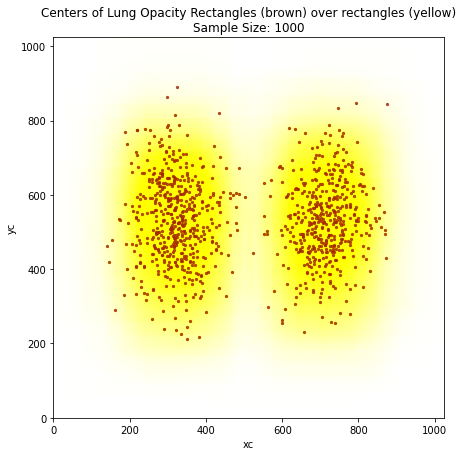

In [149]:
fig, ax = plt.subplots(1, 1, figsize = (7, 7))
target_1 = training_data[training_data['Target'] == 1]
target_sample = target_1.sample(1000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title('Centers of Lung Opacity Rectangles (brown) over rectangles (yellow)\nSample Size: 1000')
target_sample.plot.scatter(x = 'xc', y = 'yc', xlim = (0, 1024), ylim = (0, 1024), ax = ax, alpha = 0.8, marker = '.', color = 'brown')
#print(type(target_sample))
#print(target_sample.head(2))
for i, crt_sample in target_sample.iterrows():
    #print(i, crt_sample)
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))

In [150]:
sample_patientId = train_labels['patientId'][0]
print('Sample_patientId:', sample_patientId)
dcm_file = 'stage_2_train_images/'+'{}.dcm'.format(sample_patientId)
print(dcm_file)
dcm_data = dcm.read_file(dcm_file)

print('\nMetadata of the image consists of \n', dcm_data)

Sample_patientId: 0004cfab-14fd-4e49-80ba-63a80b6bddd6
stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm

Metadata of the image consists of 
 Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                   

### Finding out the number of images in traning folder

In [151]:
print('Number of images in training images folders are: {}.'.format(len(os.listdir('stage_2_train_images'))))

Number of images in training images folders are: 26684.


In [152]:
training_image_path = 'stage_2_train_images/'

df_images = pd.DataFrame({'path': glob(os.path.join(training_image_path, '*.dcm'))})
images = df_images#df_images.iloc[:15000,:]
print(images.head())
print(images.columns)
print('Shape of image dataframe:', images.shape)

                                                path
0  stage_2_train_images\0004cfab-14fd-4e49-80ba-6...
1  stage_2_train_images\000924cf-0f8d-42bd-9158-1...
2  stage_2_train_images\000db696-cf54-4385-b10b-6...
3  stage_2_train_images\000fe35a-2649-43d4-b027-e...
4  stage_2_train_images\001031d9-f904-4a23-b3e5-2...
Index(['path'], dtype='object')
Shape of image dataframe: (26684, 1)


In [153]:
temp = images.iloc[0]['path']
print(temp)
#print(type(temp))

stage_2_train_images\0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm


In [154]:
print(os.path.basename(temp))
os.path.splitext(os.path.basename(temp))

0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm


('0004cfab-14fd-4e49-80ba-63a80b6bddd6', '.dcm')

In [155]:
#glob(os.path.join(training_image_path, '*.dcm'))
images['patientId'] = images['path'].map(lambda x:os.path.splitext(os.path.basename(x))[0])
print('Columns in the training images dataframe: {}'.format(list(images.columns)))
images.head()

Columns in the training images dataframe: ['path', 'patientId']


path  \
0  stage_2_train_images\0004cfab-14fd-4e49-80ba-6...   
1  stage_2_train_images\000924cf-0f8d-42bd-9158-1...   
2  stage_2_train_images\000db696-cf54-4385-b10b-6...   
3  stage_2_train_images\000fe35a-2649-43d4-b027-e...   
4  stage_2_train_images\001031d9-f904-4a23-b3e5-2...   

                              patientId  
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  
1  000924cf-0f8d-42bd-9158-1af53881a557  
2  000db696-cf54-4385-b10b-6b16fbb3f985  
3  000fe35a-2649-43d4-b027-e67796d412e0  
4  001031d9-f904-4a23-b3e5-2c088acd19c6

### Adding the path of each patient's image in the training_data dataframe

In [156]:
training_data = training_data.merge(images, on = 'patientId', how = 'left')
print('After merging the two dataframe, the training_data has {} rows and {} columns.'.format(training_data.shape[0], training_data.shape[1]))
print('\nThe training_data dataframe as of now stands like\n')
training_data.head(10)

After merging the two dataframe, the training_data has 30227 rows and 9 columns.

The training_data dataframe as of now stands like



patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   
6  00569f44-917d-4c86-a842-81832af98c30    0.0    0.0    0.0     0.0       0   
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    0.0    0.0    0.0     0.0       0   
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1   
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1   

   number_of_boxes                         class  \
0                0  No Lung Opacity / Not Normal   
1                0  No Lung Opacity / Not Normal   
2                0  No Lung Opacity / Not Normal   
3                0                        Normal   
4                2                  Lung Opacity   
5                2                  Lung Opacity   
6                0  No Lung Opacity / Not Normal   
7                0  No Lung Opacity / Not Normal   
8                2                  Lung Opacity   
9                2                  Lung Opacity   

                                                path  
0  stage_2_train_images\0004cfab-14fd-4e49-80ba-6...  
1  stage_2_train_images\00313ee0-9eaa-42f4-b0ab-c...  
2  stage_2_train_images\00322d4d-1c29-4943-afc9-b...  
3  stage_2_train_images\003d8fa0-6bf1-40ed-b54c-a...  
4  stage_2_train_images\00436515-870c-4b36-a041-d...  
5  stage_2_train_images\00436515-870c-4b36-a041-d...  
6  stage_2_train_images\00569f44-917d-4c86-a842-8...  
7  stage_2_train_images\006cec2e-6ce2-4549-bffa-e...  
8  stage_2_train_images\00704310-78a8-4b38-8475-4...  
9  stage_2_train_images\00704310-78a8-4b38-8475-4...

In [157]:
#image_names = os.listdir('stage_2_train_images/')
#count = 0
#for i, im_nm in enumerate(image_names):
#    count = count + 1;
#    if count < 5:
#        print(i, im_nm)

### Adding more information about a patient in training_data dataframe

In [158]:
columns_to_add = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def parse_dicom_data(data_df, data_path):
  for col in columns_to_add:
    data_df[col] = None
  image_names = os.listdir('stage_2_train_images/')
  
  for i, img_name in tqdm_notebook(enumerate(image_names)):
    imagepath = os.path.join('stage_2_train_images/', img_name)
    data_img = dcm.read_file(imagepath)
    idx = (data_df['patientId'] == data_img.PatientID)
    data_df.loc[idx, 'Modality'] = data_img.Modality
    data_df.loc[idx, 'PatientAge'] = pd.to_numeric(data_img.PatientAge)
    data_df.loc[idx, 'PatientSex'] = data_img.PatientSex
    data_df.loc[idx, 'BodyPartExamined'] = data_img.BodyPartExamined
    data_df.loc[idx, 'ViewPosition'] = data_img.ViewPosition
    data_df.loc[idx, 'ConversionType'] = data_img.ConversionType
    data_df.loc[idx, 'Rows'] = data_img.Rows
    data_df.loc[idx, 'Columns'] = data_img.Columns
    data_df.loc[idx, 'PixelSpacing'] = str.format("{:4.3f}", data_img.PixelSpacing[0])

In [159]:
parse_dicom_data(training_data, 'stage_2_train_images/')

0it [00:00, ?it/s]

In [160]:
print('\nAfter parsing the information from the dicom images, our training_data dataframe has {} rows and {} columns and it looks like:\n'.format(training_data.shape[0], training_data.shape[1]))
training_data.head()


After parsing the information from the dicom images, our training_data dataframe has 30227 rows and 18 columns and it looks like:



patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                0  No Lung Opacity / Not Normal   
1                0  No Lung Opacity / Not Normal   
2                0  No Lung Opacity / Not Normal   
3                0                        Normal   
4                2                  Lung Opacity   

                                                path Modality PatientAge  \
0  stage_2_train_images\0004cfab-14fd-4e49-80ba-6...       CR         51   
1  stage_2_train_images\00313ee0-9eaa-42f4-b0ab-c...       CR         48   
2  stage_2_train_images\00322d4d-1c29-4943-afc9-b...       CR         19   
3  stage_2_train_images\003d8fa0-6bf1-40ed-b54c-a...       CR         28   
4  stage_2_train_images\00436515-870c-4b36-a041-d...       CR         32   

  PatientSex BodyPartExamined ViewPosition ConversionType  Rows Columns  \
0          F            CHEST           PA            WSD  1024    1024   
1          F            CHEST           PA            WSD  1024    1024   
2          M            CHEST           AP            WSD  1024    1024   
3          M            CHEST           PA            WSD  1024    1024   
4          F            CHEST           AP            WSD  1024    1024   

  PixelSpacing  
0        0.143  
1        0.194  
2        0.168  
3        0.143  
4        0.139

In [161]:
print('Modality for the images obtained is: {} \n'.format(training_data['Modality'].unique()[0]))
print('The images obtained are of {} areas.'.format(training_data['BodyPartExamined'].unique()[0]))

Modality for the images obtained is: CR 

The images obtained are of CHEST areas.


In [162]:
## Function for determing the distribution (% - wise) of values of a prticulat feature
def get_feature_distribution(data, feature):
  # Count for each label
  label_counts = data[feature].value_counts()
  # Count the number of items in each class
  total_samples = len(data)
  print("Feature: {}".format(feature))
  for i in range(len(label_counts)):
    label = label_counts.index[i]
    count = label_counts.values[i]
    percent = int((count / total_samples) * 10000) / 100
    print("{:<30s}: {} which is {}% of the total data in the dataset".format(label, count, percent))

In [163]:
get_feature_distribution(training_data.drop_duplicates('patientId'), 'ViewPosition')

Feature: ViewPosition
PA                            : 14511 which is 54.38% of the total data in the dataset
AP                            : 12173 which is 45.61% of the total data in the dataset


The distribution of View Position when there is an evidence of Pneumonia:



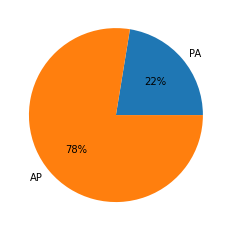

In [164]:
print('The distribution of View Position when there is an evidence of Pneumonia:\n')
_ = training_data.drop_duplicates('patientId').loc[training_data['Target'] == 1, 'ViewPosition'].value_counts().sort_index(ascending = False).plot(kind = 'pie', autopct = '%.0f%%').set_ylabel('')

Plot x and y centers of bounding box for patient having Pneumonia


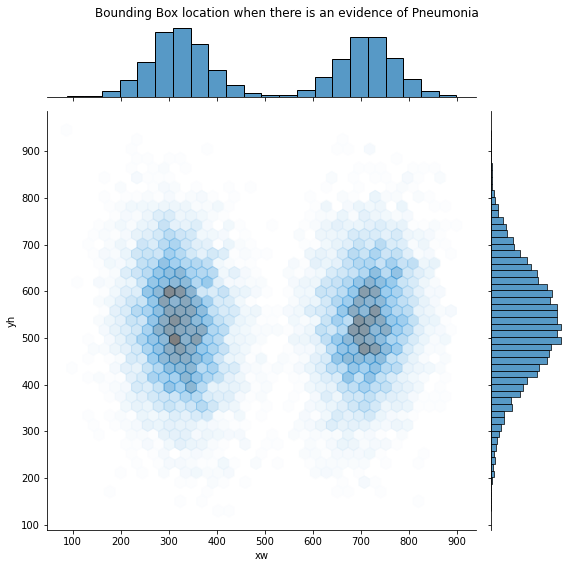

In [165]:
print('Plot x and y centers of bounding box for patient having Pneumonia')
bboxes = training_data[training_data['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width']/2
bboxes['yh'] = bboxes['y'] + bboxes['height']/2

g = sns.jointplot(x = bboxes['xw'], y = bboxes['yh'], data = bboxes,
                  kind = 'hex', alpha = 0.5, size = 8)
plt.suptitle('Bounding Box location when there is an evidence of Pneumonia')
#plt.tight_layout()
plt.subplots_adjust(top = 0.95)

In [166]:
def bboxes_scatter(data, color_point, color_window, text):
  fig, ax = plt.subplots(1, 1, figsize = (7, 7))
  plt.title('Plotting centers of Lung Opacity\n{}'.format(text))
  data.plot.scatter(x = 'xw', y = 'yh', xlim = (0, 1024), ylim = (0, 1024), ax = ax, alpha = 0.8, marker = ".", color = color_point)
  for i, crt_sample in data.iterrows():
    ax.add_patch(Rectangle(xy = (crt_sample['x'], crt_sample['y']), width = crt_sample['width'], height = crt_sample['height'], alpha = 3.5e-3, color = color_window))

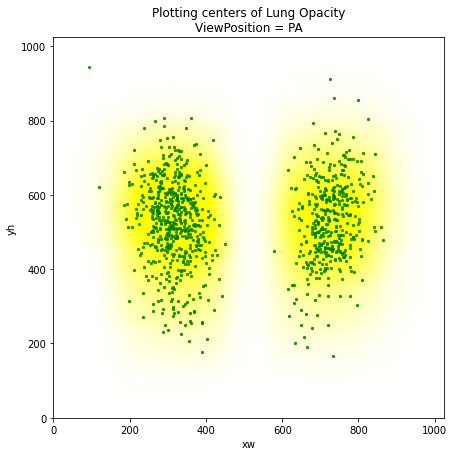

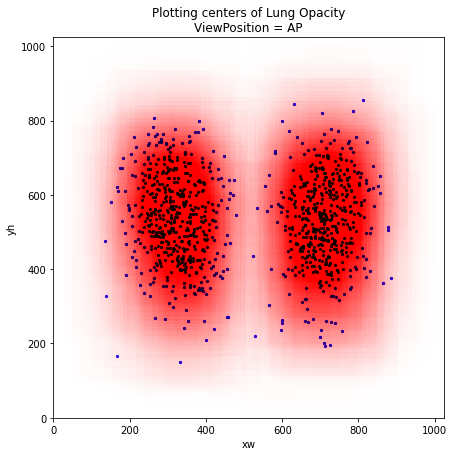

In [167]:
#data_PA = bboxes[bboxes['ViewPosition'] == 'PA'].sample(100)
#data_AP = bboxes[bboxes['ViewPosition'] == 'AP'].sample(100)

data_PA = bboxes[bboxes['ViewPosition'] == 'PA'].sample(1000)
data_AP = bboxes[bboxes['ViewPosition'] == 'AP'].sample(1000)

bboxes_scatter(data_PA, 'green', 'yellow', 'ViewPosition = PA')
bboxes_scatter(data_AP, 'blue', 'red', 'ViewPosition = AP')

In [168]:
print('Conversion Type for the data in Training Data: ', training_data['ConversionType'].unique()[0])
print(f'The training images has {training_data.Rows.unique()[0]} rows and {training_data.Columns.unique()[0]} columns.')

Conversion Type for the data in Training Data:  WSD
The training images has 1024 rows and 1024 columns.


In [169]:
#training_data.head()

In [170]:
#training_data.Rows.unique()

In [171]:
def drawgraphs(data_file, columns, hue = False, width = 15, showdistribution = True):
  if (hue):
    print('Creating graph for: {} and {}'.format(columns, hue))
  else:  
    print('Creating graph for : {}'.format(columns))
  length = len(columns) * 6
  total = float(len(data_file))
  #print('Lenght:{}, total:{}'.format(length,total))

  fig, axes = plt.subplots(nrows = len(columns) if len(columns) > 1 else 1, ncols = 1, figsize = (width, length))
  for index, content in enumerate(columns):
    plt.title(content)

    currentaxes = 0
    if (len(columns) > 1):
      currentaxes = axes[index]
    else:
      currentaxes = axes
    
    if (hue):
      sns.countplot(x = columns[index], data = data_file, ax = currentaxes, hue = hue)
    else:
      sns.countplot(x = columns[index], data = data_file, ax = currentaxes)

    if(showdistribution):
      for p in (currentaxes.patches):
        height = p.get_height()
        if (height > 0 and total > 0):
          currentaxes.text(p.get_x() + p.get_width()/2., height + 3, '{:1.2f}%'.format(100*height/total), ha = "center")

In [172]:
training_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                0  No Lung Opacity / Not Normal   
1                0  No Lung Opacity / Not Normal   
2                0  No Lung Opacity / Not Normal   
3                0                        Normal   
4                2                  Lung Opacity   

                                                path Modality PatientAge  \
0  stage_2_train_images\0004cfab-14fd-4e49-80ba-6...       CR         51   
1  stage_2_train_images\00313ee0-9eaa-42f4-b0ab-c...       CR         48   
2  stage_2_train_images\00322d4d-1c29-4943-afc9-b...       CR         19   
3  stage_2_train_images\003d8fa0-6bf1-40ed-b54c-a...       CR         28   
4  stage_2_train_images\00436515-870c-4b36-a041-d...       CR         32   

  PatientSex BodyPartExamined ViewPosition ConversionType  Rows Columns  \
0          F            CHEST           PA            WSD  1024    1024   
1          F            CHEST           PA            WSD  1024    1024   
2          M            CHEST           AP            WSD  1024    1024   
3          M            CHEST           PA            WSD  1024    1024   
4          F            CHEST           AP            WSD  1024    1024   

  PixelSpacing  
0        0.143  
1        0.194  
2        0.168  
3        0.143  
4        0.139

In [173]:
get_feature_distribution(training_data.drop_duplicates('patientId'), 'PatientSex')

Feature: PatientSex
M                             : 15166 which is 56.83% of the total data in the dataset
F                             : 11518 which is 43.16% of the total data in the dataset


### See the distribution class and target for different patient sex

Creating graph for: ['PatientSex'] and class


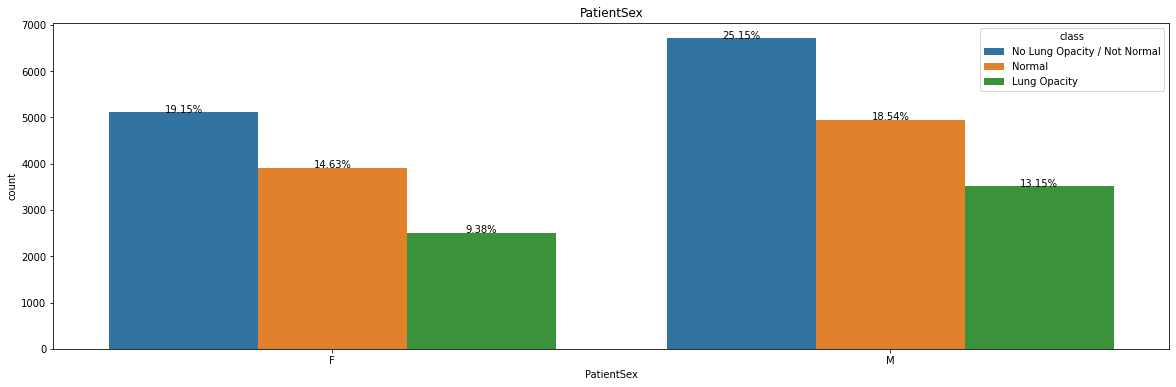

In [174]:
drawgraphs(data_file = training_data.drop_duplicates('patientId'), columns = ['PatientSex'], hue = 'class', width = 20, showdistribution = True)

Creating graph for: ['PatientSex'] and Target


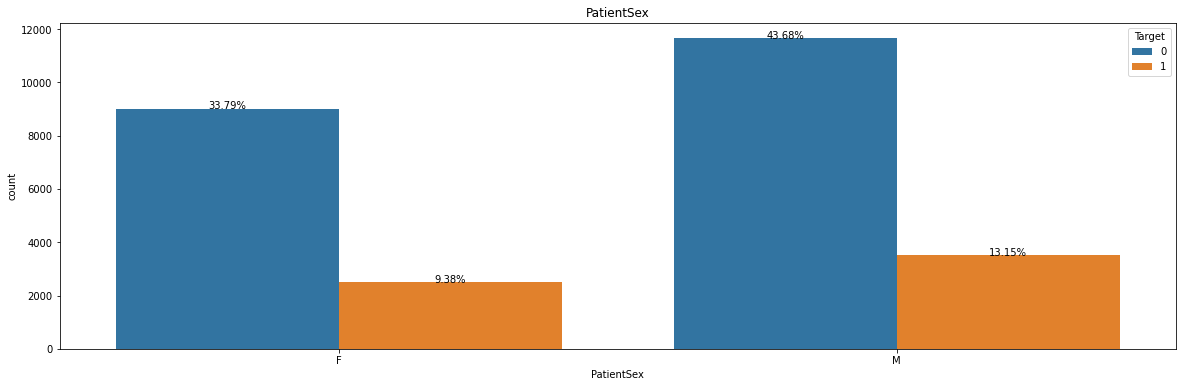

In [175]:
drawgraphs(data_file = training_data.drop_duplicates('patientId'), columns = ['PatientSex'], hue = 'Target', width = 20, showdistribution = True)

### See the location lung opacity patches for males and females

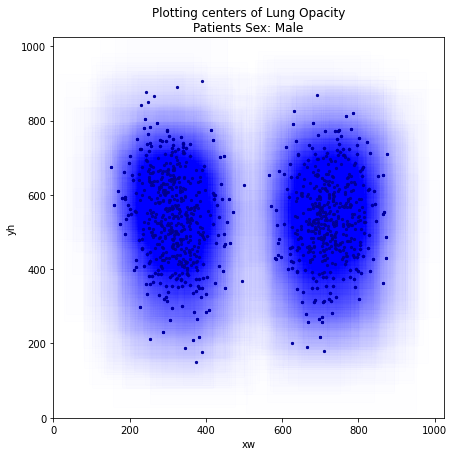

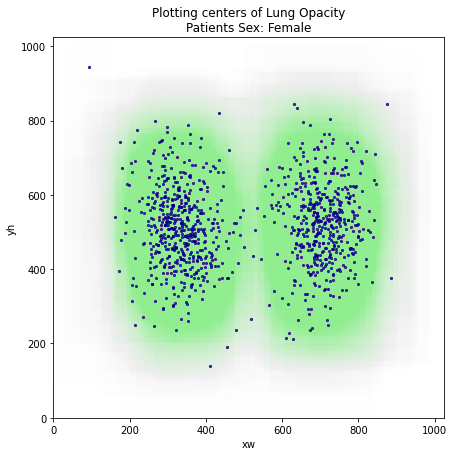

In [176]:
data_male = bboxes[bboxes['PatientSex'] == 'M'].sample(1000)
data_female = bboxes[bboxes['PatientSex'] == 'F'].sample(1000)

bboxes_scatter(data_male, "darkblue", "blue", "Patients Sex: Male")
bboxes_scatter(data_female, "darkblue", "lightgreen", "Patients Sex: Female")

### See the how the patient's age is distributed, remove the outliers

In [177]:
print('The minimum and maximum recorded age of the patients are {} and {} respectively.'.format(training_data['PatientAge'].min(), training_data['PatientAge'].max()))

The minimum and maximum recorded age of the patients are 1 and 155 respectively.


The number of outliers in `PatientAge` out of 30227 records are:  5

The ages which are in the outlier categories are: [148, 151, 153, 150, 155]


Text(0.5, 1.0, 'Outliers in PatientAge')

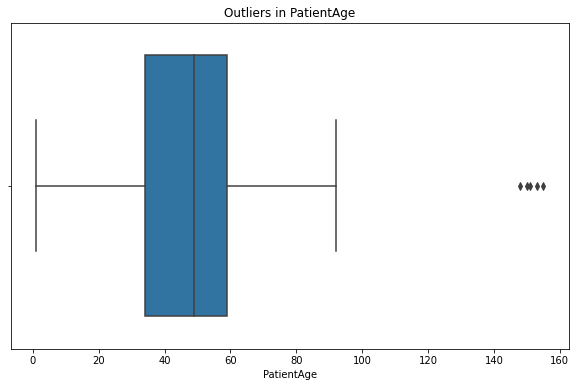

In [178]:
age_25 = np.percentile(training_data['PatientAge'], 25)
age_75 = np.percentile(training_data['PatientAge'], 75)
iqr_age = age_75 - age_25
cutoff_age = 1.5 * iqr_age

low_lim_age = age_25 - cutoff_age
upp_lim_age = age_75 + cutoff_age

outlier_age = [x for x in training_data['PatientAge'] if x < low_lim_age or x > upp_lim_age]
print('The number of outliers in `PatientAge` out of',training_data.shape[0], 'records are: ', len(outlier_age))
print('\nThe ages which are in the outlier categories are:', outlier_age)

fig = plt.figure(figsize = (10, 6))
sns.boxplot(training_data['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

Creating graph for : ['PatientAge']


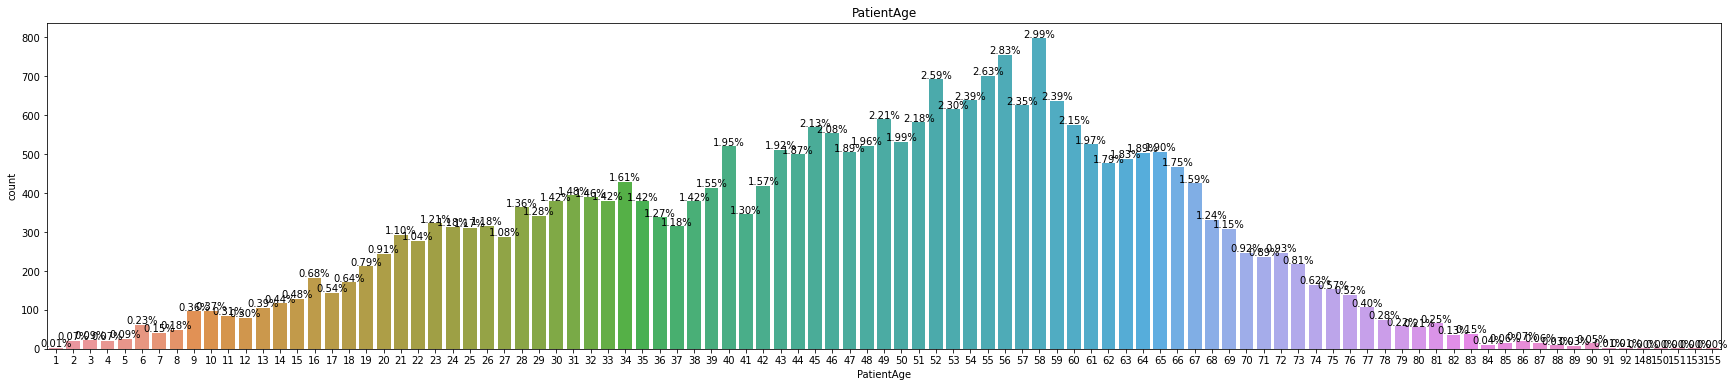

In [179]:
drawgraphs(data_file = training_data.drop_duplicates('patientId'), columns = ['PatientAge'], width = 30, showdistribution = True)

In [180]:
print('Removing the outliers from `PatientAge`')
training_data['PatientAge'] = training_data['PatientAge'].clip(training_data['PatientAge'].min(), 100)
training_data['PatientAge'].describe().astype(int)

Removing the outliers from `PatientAge`


count     30227
unique       93
top          58
freq        955
Name: PatientAge, dtype: int32

In [181]:
#drawgraphs(data_file = training_data.drop_duplicates('patientId'), columns = ['PatientAge'], width = 30, showdistribution = True)

Distribution of `PatientAge`: Overall and Target = 1


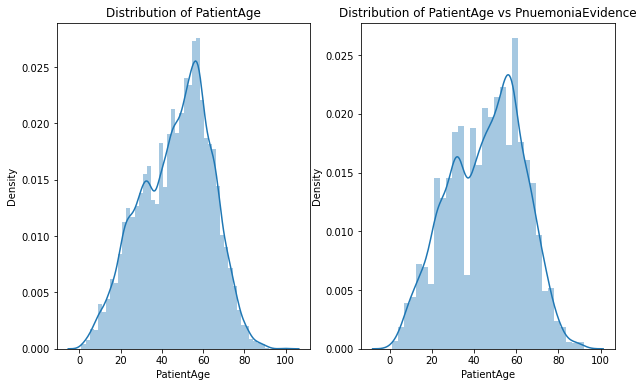

In [182]:
print('Distribution of `PatientAge`: Overall and Target = 1')
fig = plt.figure(figsize = (10, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(training_data['PatientAge']).set_title('Distribution of PatientAge'))

ax = fig.add_subplot(122)
g = (sns.distplot(training_data.drop_duplicates('patientId').loc[training_data['Target'] == 1, 'PatientAge']).set_title('Distribution of PatientAge vs PnuemoniaEvidence'))

### Creating bins (of size 10) for the 'PatientAge'

In [183]:
custom_array = np.linspace(0, 100, 11)
training_data['PatientAgeBins'] = pd.cut(training_data['PatientAge'], custom_array)
training_data.drop_duplicates('patientId')['PatientAgeBins'].value_counts()

(50.0, 60.0]     6619
(40.0, 50.0]     5048
(60.0, 70.0]     4279
(30.0, 40.0]     3936
(20.0, 30.0]     3205
(10.0, 20.0]     1468
(70.0, 80.0]     1452
(0.0, 10.0]       435
(80.0, 90.0]      233
(90.0, 100.0]       9
Name: PatientAgeBins, dtype: int64

In [184]:
print('After adding the bin column, the dataset is:\n')
training_data.head()

After adding the bin column, the dataset is:



patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                0  No Lung Opacity / Not Normal   
1                0  No Lung Opacity / Not Normal   
2                0  No Lung Opacity / Not Normal   
3                0                        Normal   
4                2                  Lung Opacity   

                                                path Modality PatientAge  \
0  stage_2_train_images\0004cfab-14fd-4e49-80ba-6...       CR         51   
1  stage_2_train_images\00313ee0-9eaa-42f4-b0ab-c...       CR         48   
2  stage_2_train_images\00322d4d-1c29-4943-afc9-b...       CR         19   
3  stage_2_train_images\003d8fa0-6bf1-40ed-b54c-a...       CR         28   
4  stage_2_train_images\00436515-870c-4b36-a041-d...       CR         32   

  PatientSex BodyPartExamined ViewPosition ConversionType  Rows Columns  \
0          F            CHEST           PA            WSD  1024    1024   
1          F            CHEST           PA            WSD  1024    1024   
2          M            CHEST           AP            WSD  1024    1024   
3          M            CHEST           PA            WSD  1024    1024   
4          F            CHEST           AP            WSD  1024    1024   

  PixelSpacing PatientAgeBins  
0        0.143   (50.0, 60.0]  
1        0.194   (40.0, 50.0]  
2        0.168   (10.0, 20.0]  
3        0.143   (20.0, 30.0]  
4        0.139   (30.0, 40.0]

Creating graph for : ['PatientAgeBins']


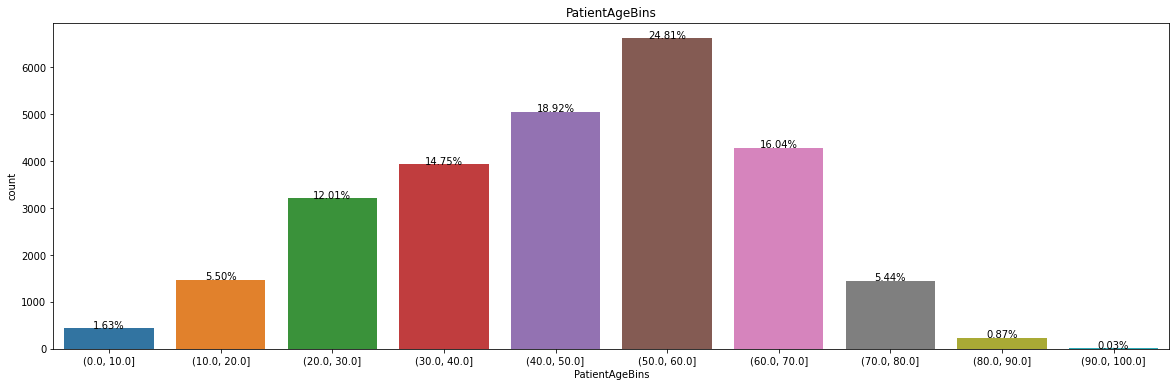

In [185]:
drawgraphs(data_file = training_data.drop_duplicates('patientId'), columns = ['PatientAgeBins'], width = 20, showdistribution = True)

Creating graph for: ['PatientAgeBins'] and PatientSex


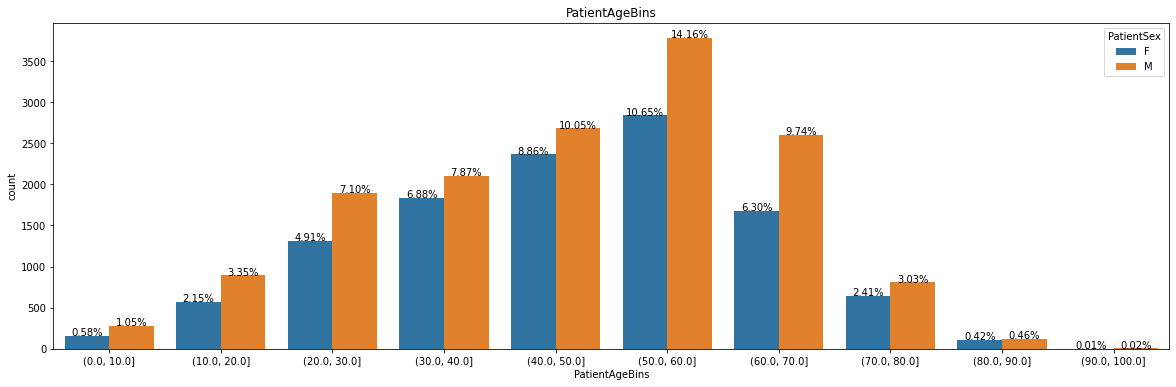

In [186]:
drawgraphs(data_file = training_data.drop_duplicates('patientId'), columns = ['PatientAgeBins'], hue = 'PatientSex', width = 20, showdistribution = True)

Creating graph for: ['PatientAgeBins'] and class


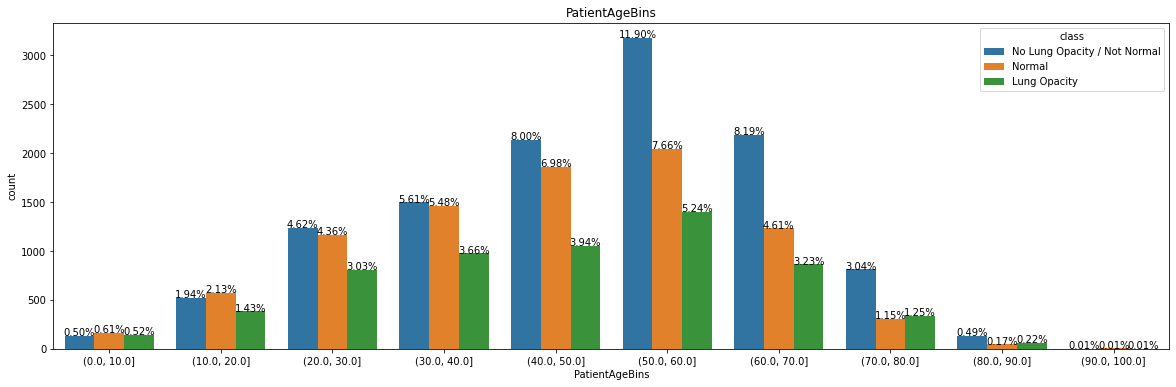

In [187]:
drawgraphs(data_file = training_data.drop_duplicates('patientId'), columns = ['PatientAgeBins'], hue = 'class', width = 20, showdistribution = True)

Creating graph for: ['PatientAgeBins'] and Target


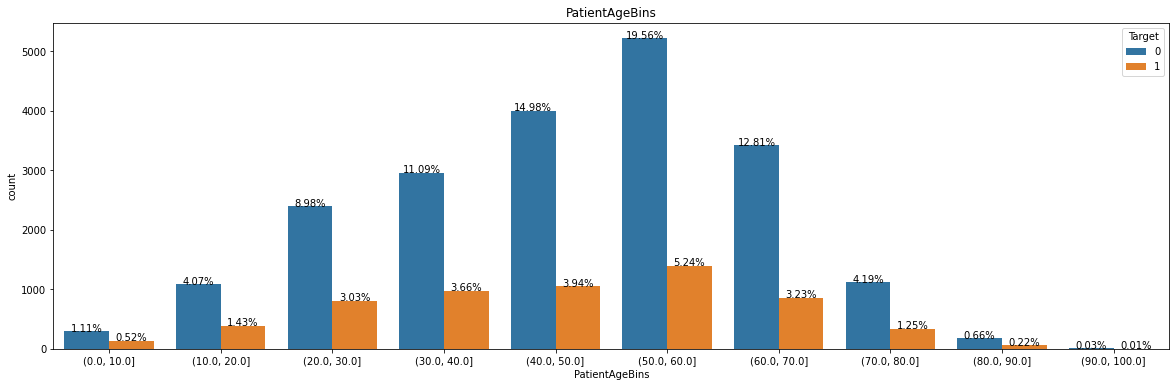

In [188]:
drawgraphs(data_file = training_data.drop_duplicates('patientId'), columns = ['PatientAgeBins'], hue = 'Target', width = 20, showdistribution = True)

### Plot the the locations of lung opacity patches different age-bins

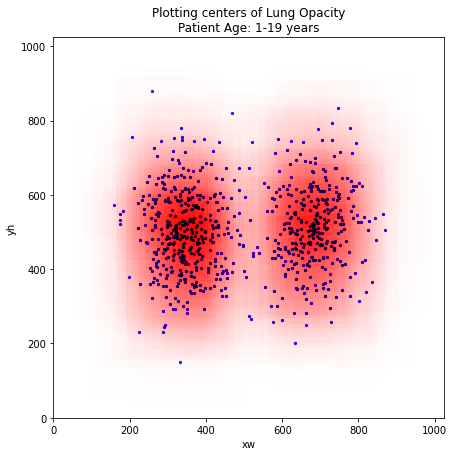

In [189]:
data_age_19 = bboxes[bboxes['PatientAge'] < 20]
data_age_20_34 = bboxes[(bboxes['PatientAge'] >= 20) & (bboxes['PatientAge'] < 35)]
data_age_35_49 = bboxes[(bboxes['PatientAge'] >= 35) & (bboxes['PatientAge'] < 50)]
data_age_50_64 = bboxes[(bboxes['PatientAge'] >= 50) & (bboxes['PatientAge'] < 65)]
data_age_65 = bboxes[bboxes['PatientAge'] >= 65]

bboxes_scatter(data_age_19,'blue', 'red', 'Patient Age: 1-19 years')

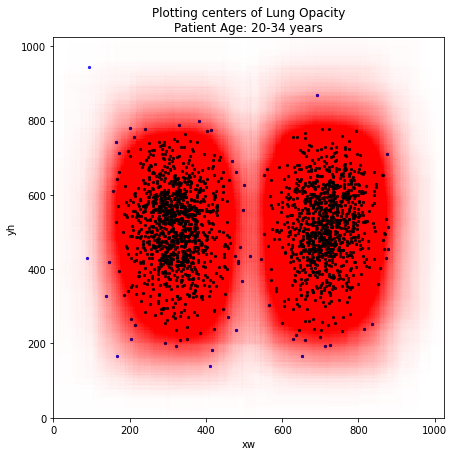

In [190]:
bboxes_scatter(data_age_20_34, 'blue', 'red', 'Patient Age: 20-34 years')

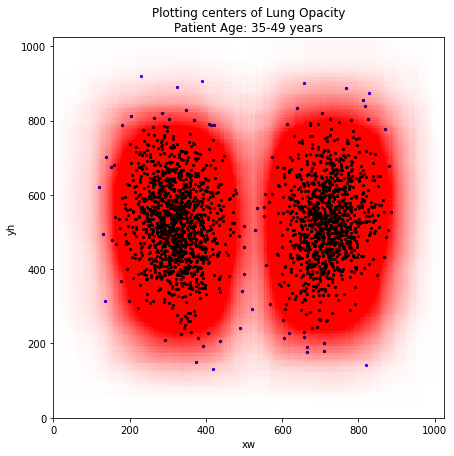

In [191]:
bboxes_scatter(data_age_35_49, 'blue', 'red', 'Patient Age: 35-49 years')

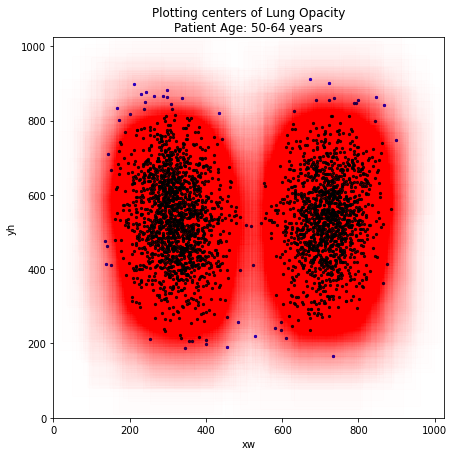

In [192]:
bboxes_scatter(data_age_50_64, 'blue', 'red', 'Patient Age: 50-64 years')

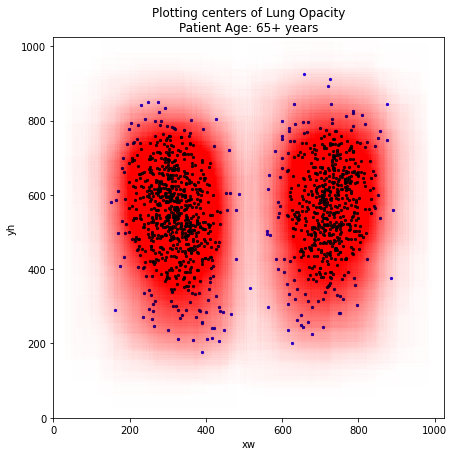

In [193]:
bboxes_scatter(data_age_65, 'blue', 'red', 'Patient Age: 65+ years')

### Show the X-ray images various patients

In [194]:
def show_dicom_images(data, df, img_path):
  #print('Data and its shape:',type(data), data.shape)
  #print('df and its shape:',type(df), df.shape)
  #print('data',data)
  #print('\ndata.T', data.T)
  #print(data.T.to_dict())
  img_data = list(data.T.to_dict().values())
  #print('\n\n img_data', img_data)
  img_col = 3;
  img_row = int(np.ceil(data.shape[0]/img_col))
  f, ax = plt.subplots(img_row, img_col, figsize = (16, img_row*6))   
  #f, ax = plt.subplots(3, 3, figsize = (16, 18))
  #count = 1
  for i, row in enumerate(img_data):
    #if count == 1:
    #    print('i and row:', i, row)
    #    count = count+1
    image = row['patientId'] + '.dcm'
    path = os.path.join(img_path, image)
    #print('path:', path)
    data = dcm.read_file(path)
    #print('type of data is:', type(data))
    rows = df[df['patientId'] == row['patientId']]
    print('rows shape', rows.shape)
    #print(rows)
    age = rows.PatientAge.unique().tolist()[0]
    sex = data.PatientSex
    #print('Sex: ',sex)
    part = data.BodyPartExamined
    vp = data.ViewPosition
    modality = data.Modality
    data_img = dcm.dcmread(path)
    ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                            .format(row['patientId'], age, sex, part,
                                    vp, modality, row['Target'],
                                    row['class'], row['x'],
                                    row['y'], row['width'],
                                    row['height']))
    box_data = list(rows.T.to_dict().values())
    
    for j, row in enumerate(box_data):
      ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                                        width = row['width'], height = row['height'],
                                        color = 'blue', alpha = 0.15))
  plt.show()

In [195]:
#training_data.loc[(training_data['Target'] == 0)].iloc[:15,:]

In [196]:
#training_data.loc[(training_data['Target'] == 1)].head()

rows shape (1, 19)
rows shape (1, 19)
rows shape (1, 19)
rows shape (1, 19)
rows shape (1, 19)
rows shape (1, 19)
rows shape (1, 19)
rows shape (1, 19)
rows shape (1, 19)
rows shape (1, 19)
rows shape (1, 19)
rows shape (1, 19)
rows shape (1, 19)
rows shape (1, 19)
rows shape (1, 19)


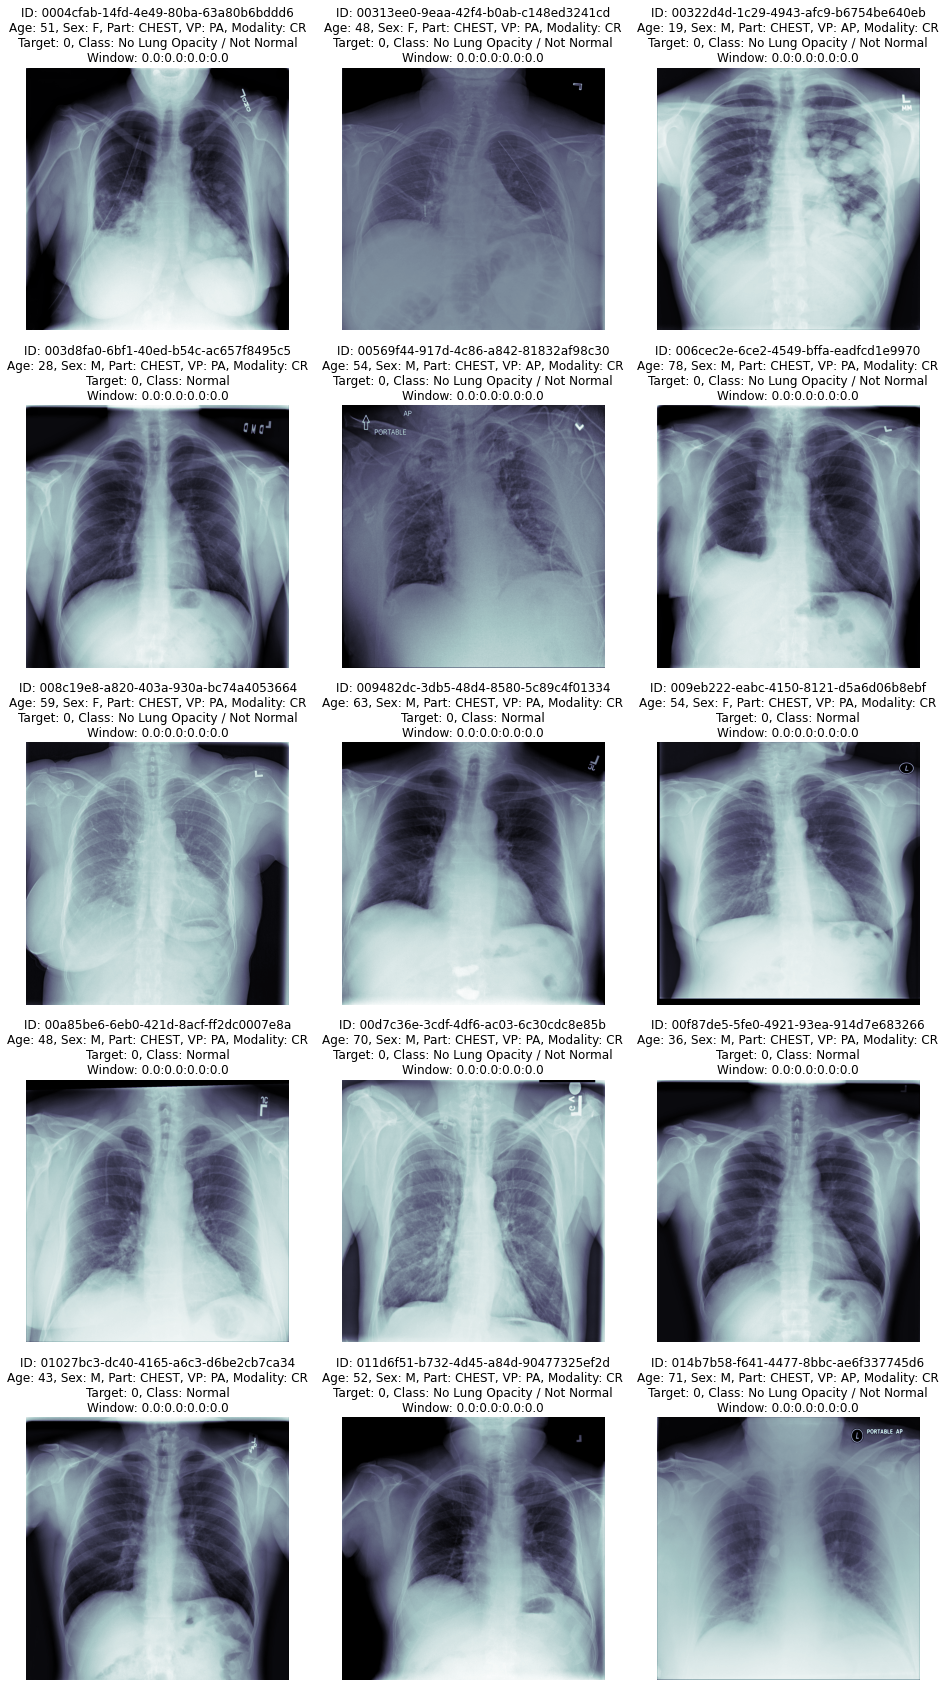

In [197]:
show_dicom_images(data = training_data.loc[(training_data['Target'] == 0)].iloc[:15,:],
                  df = training_data, img_path = 'stage_2_train_images/')
#show_dicom_images(data = training_data.loc[(training_data['Target'] == 0)].sample(15),
#                  df = training_data, img_path = 'stage_2_train_images/')

rows shape (2, 19)
rows shape (2, 19)
rows shape (2, 19)
rows shape (2, 19)
rows shape (2, 19)
rows shape (2, 19)
rows shape (2, 19)
rows shape (2, 19)
rows shape (2, 19)
rows shape (2, 19)
rows shape (1, 19)
rows shape (2, 19)
rows shape (2, 19)
rows shape (2, 19)
rows shape (2, 19)


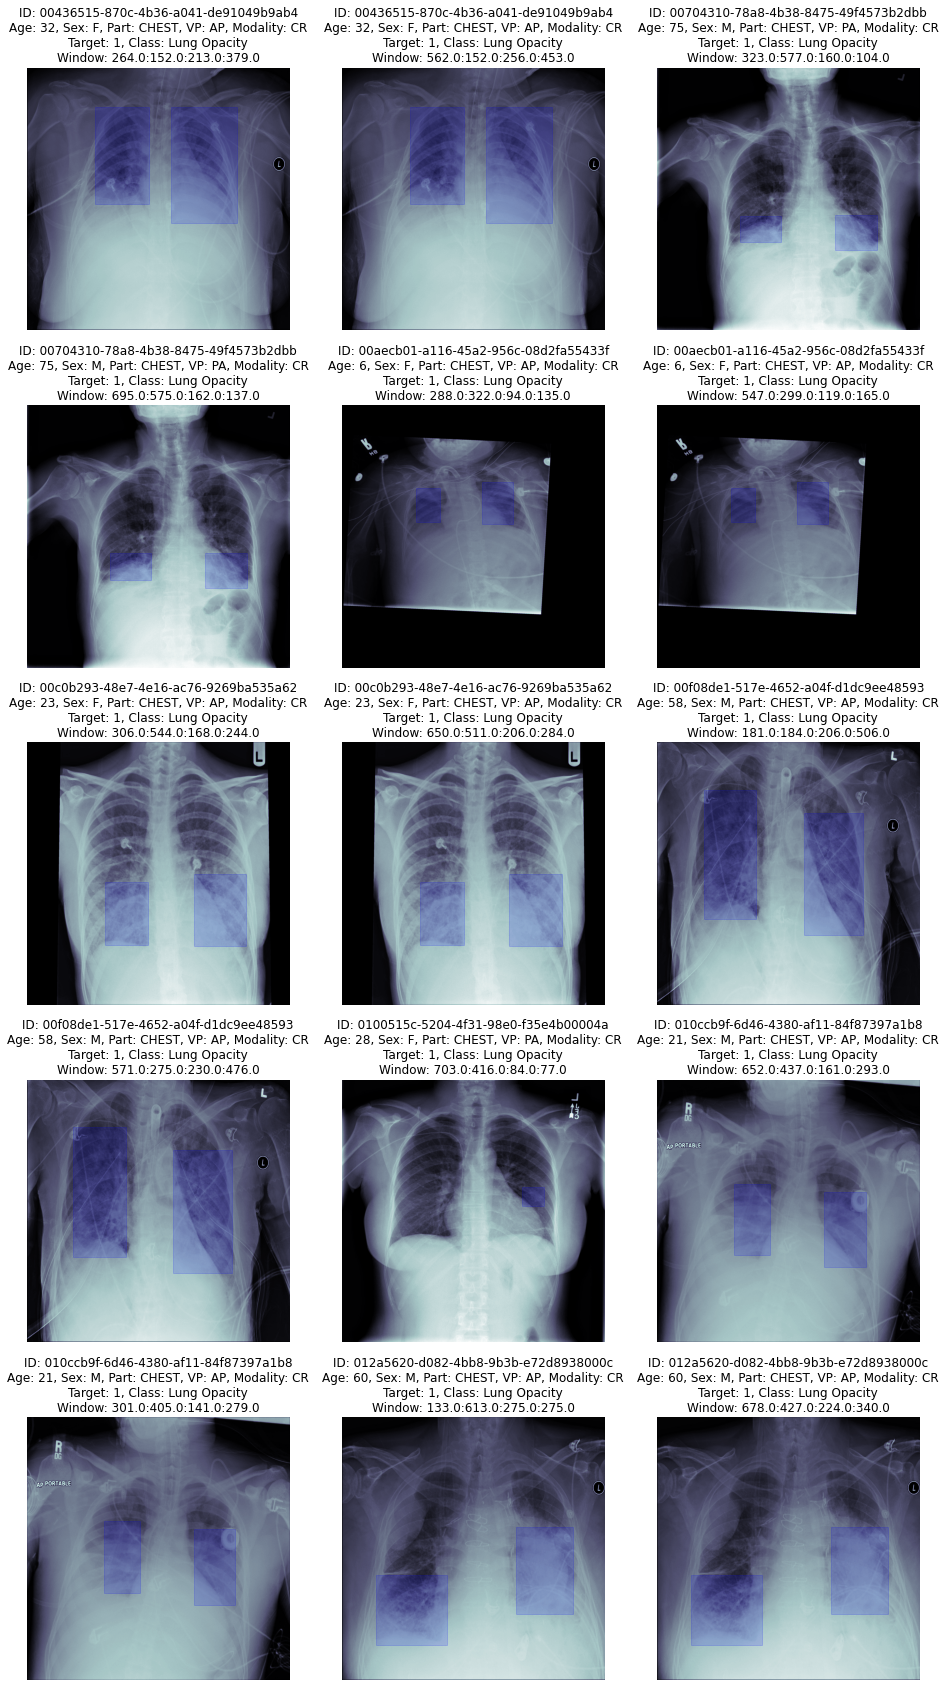

In [198]:
show_dicom_images(data = training_data.loc[(training_data['Target'] == 1)].iloc[:15,:],
                  df = training_data, img_path = 'stage_2_train_images/')

#show_dicom_images(data = training_data.loc[(training_data['Target'] == 1)].sample(15),
#                  df = training_data, img_path = 'stage_2_train_images/')


### Now develop a model

In [199]:
# params we will probably want to do some hyperparameter optimization later
BASE_MODEL= 'DenseNet121'
IMG_SIZE = (512, 512) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 24 # [1, 8, 16, 24]
DENSE_COUNT = 128 # [32, 64, 128, 256]
DROPOUT = 0.5 # [0, 0.25, 0.5]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]
TRAIN_SAMPLES = 6000 # [3000, 6000, 15000]
TEST_SAMPLES = 600
USE_ATTN = False # [True, False]

In [200]:
#training_data.head()

In [201]:
training_data.replace(np.nan, 0)
training_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                0  No Lung Opacity / Not Normal   
1                0  No Lung Opacity / Not Normal   
2                0  No Lung Opacity / Not Normal   
3                0                        Normal   
4                2                  Lung Opacity   

                                                path Modality PatientAge  \
0  stage_2_train_images\0004cfab-14fd-4e49-80ba-6...       CR         51   
1  stage_2_train_images\00313ee0-9eaa-42f4-b0ab-c...       CR         48   
2  stage_2_train_images\00322d4d-1c29-4943-afc9-b...       CR         19   
3  stage_2_train_images\003d8fa0-6bf1-40ed-b54c-a...       CR         28   
4  stage_2_train_images\00436515-870c-4b36-a041-d...       CR         32   

  PatientSex BodyPartExamined ViewPosition ConversionType  Rows Columns  \
0          F            CHEST           PA            WSD  1024    1024   
1          F            CHEST           PA            WSD  1024    1024   
2          M            CHEST           AP            WSD  1024    1024   
3          M            CHEST           PA            WSD  1024    1024   
4          F            CHEST           AP            WSD  1024    1024   

  PixelSpacing PatientAgeBins  
0        0.143   (50.0, 60.0]  
1        0.194   (40.0, 50.0]  
2        0.168   (10.0, 20.0]  
3        0.143   (20.0, 30.0]  
4        0.139   (30.0, 40.0]

In [202]:
image_bbox_df= training_data[["patientId","x","y","width","height", "Target","number_of_boxes","class", "path"]]
image_bbox_df.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                0  No Lung Opacity / Not Normal   
1                0  No Lung Opacity / Not Normal   
2                0  No Lung Opacity / Not Normal   
3                0                        Normal   
4                2                  Lung Opacity   

                                                path  
0  stage_2_train_images\0004cfab-14fd-4e49-80ba-6...  
1  stage_2_train_images\00313ee0-9eaa-42f4-b0ab-c...  
2  stage_2_train_images\00322d4d-1c29-4943-afc9-b...  
3  stage_2_train_images\003d8fa0-6bf1-40ed-b54c-a...  
4  stage_2_train_images\00436515-870c-4b36-a041-d...

In [203]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
class_enc = LabelEncoder()
image_bbox_df['class_idx'] = class_enc.fit_transform(image_bbox_df['class'])
oh_enc = OneHotEncoder(sparse=False)
image_bbox_df['class_vec'] = oh_enc.fit_transform(
    image_bbox_df['class_idx'].values.reshape(-1, 1)).tolist() 
image_bbox_df.sample(3)

patientId      x      y  width  height  \
21334  c2802780-8f5c-4240-8d71-0be1664a8b6f   99.0  233.0  257.0   504.0   
29066  02cfa7d1-61e0-4d9e-8664-9a7469ccab76  299.0  397.0  181.0   348.0   
11472  77293530-8a74-449c-b423-85849cee8da2    0.0    0.0    0.0     0.0   

       Target  number_of_boxes         class  \
21334       1                2  Lung Opacity   
29066       1                2  Lung Opacity   
11472       0                0        Normal   

                                                    path  class_idx  \
21334  stage_2_train_images\c2802780-8f5c-4240-8d71-0...          0   
29066  stage_2_train_images\02cfa7d1-61e0-4d9e-8664-9...          0   
11472  stage_2_train_images\77293530-8a74-449c-b423-8...          2   

             class_vec  
21334  [1.0, 0.0, 0.0]  
29066  [1.0, 0.0, 0.0]  
11472  [0.0, 0.0, 1.0]

In [204]:
from sklearn.model_selection import train_test_split
image_df = image_bbox_df.groupby('patientId').apply(lambda x: x.sample(1))
raw_train_df, valid_df = train_test_split(image_df, test_size=0.25, random_state=2018,
                                    stratify=image_df['class'])
print(raw_train_df.shape, 'training data')
print(valid_df.shape, 'validation data')

(20013, 11) training data
(6671, 11) validation data


<AxesSubplot:xlabel='class'>

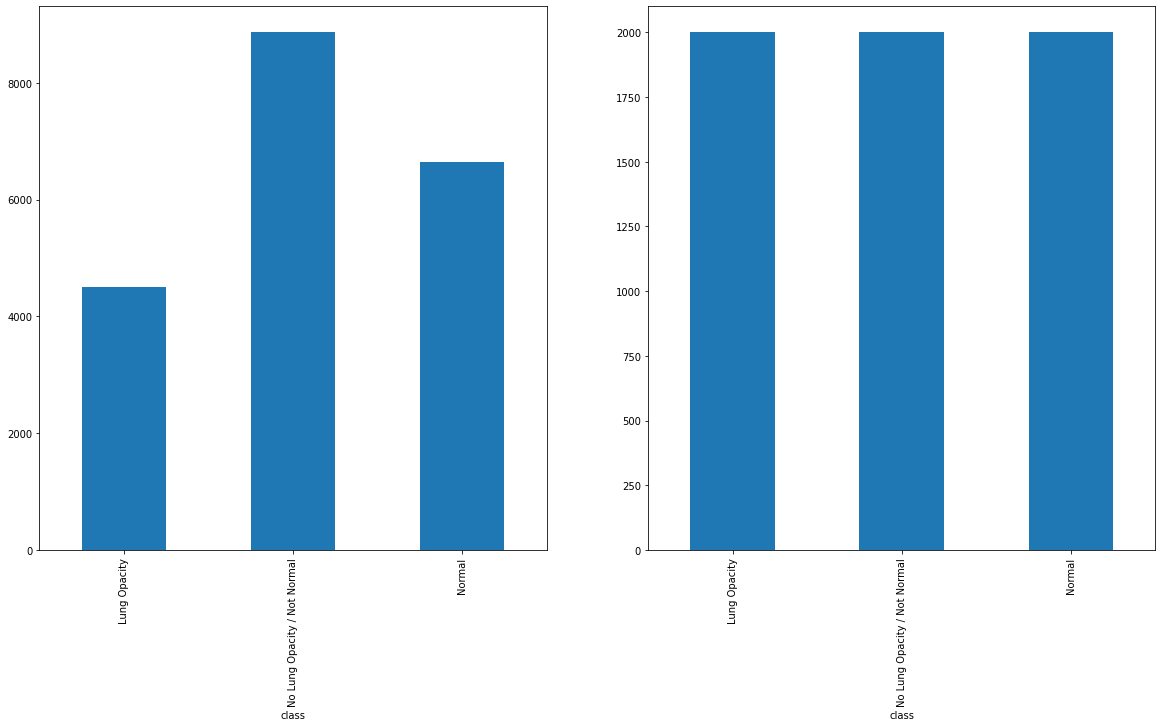

In [205]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
raw_train_df.groupby('class').size().plot.bar(ax=ax1)
train_df = raw_train_df.groupby('class').\
    apply(lambda x: x.sample(TRAIN_SAMPLES//3)).\
    reset_index(drop=True)
train_df.groupby('class').size().plot.bar(ax=ax2) 


In [206]:
print(train_df.shape[0], 'new training size')
train_df.head()

6000 new training size


patientId      x      y  width  height  Target  \
0  b5efdc67-97a4-413f-b62a-7d3edb9de1a1  328.0  537.0  189.0   122.0       1   
1  a7a45cd9-785e-402c-a66c-4762b71ec4bb  581.0  305.0  238.0   443.0       1   
2  938fb8f0-71d5-4c4b-98d4-0539a59a9ba4  675.0  668.0  236.0   356.0       1   
3  3687784e-47a5-40d3-aa45-5cae7dd23e8b  186.0  189.0  259.0   621.0       1   
4  e0227184-955d-4bfd-8eeb-0bc0b2a21a66  740.0  572.0  151.0   123.0       1   

   number_of_boxes         class  \
0                1  Lung Opacity   
1                2  Lung Opacity   
2                1  Lung Opacity   
3                2  Lung Opacity   
4                1  Lung Opacity   

                                                path  class_idx  \
0  stage_2_train_images\b5efdc67-97a4-413f-b62a-7...          0   
1  stage_2_train_images\a7a45cd9-785e-402c-a66c-4...          0   
2  stage_2_train_images\938fb8f0-71d5-4c4b-98d4-0...          0   
3  stage_2_train_images\3687784e-47a5-40d3-aa45-5...          0   
4  stage_2_train_images\e0227184-955d-4bfd-8eeb-0...          0   

         class_vec  
0  [1.0, 0.0, 0.0]  
1  [1.0, 0.0, 0.0]  
2  [1.0, 0.0, 0.0]  
3  [1.0, 0.0, 0.0]  
4  [1.0, 0.0, 0.0]

In [235]:
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input
import pydicom

def read_dicom_image(in_path):
    #img_arr = pydicom.read_file(in_path).resize(IMG_SIZE).pixel_array
    #img_arr = pydicom.read_file(in_path)#.pixel_array
    #return img_arr/img_arr.max()

#def read_dicom_image(in_path):
        # return numpy array
    img_arr = pydicom.read_file(in_path).pixel_array
    img_arr = img_arr/img_arr.max()
    img_arr = (255*img_arr).clip(0, 255).astype(np.uint8)
    img_arr = Image.fromarray(img_arr).convert('RGB') # model expects 3 channel image
    return img_arr

In [236]:
#f, ax = plt.subplots(1, 1, figsize = (16, 6))   
count = 1;
X_train = train_df['path'].copy()
print(X_train)
#for i in range(train_df.shape[0]):
for i, f in enumerate(X_train):
    #print(i)
    image_path = f; #train_df.iloc[i]['path']
    if count == 2:
        print(image_path)        
        
    data_img = read_dicom_image(image_path)
    X_train[i] = preprocess_input(np.array(data_img, dtype=np.float32)) # Convert to float32 array
    #print(type(data_img), data_img.shape)# dcm.dcmread(image_path)
    #print(data_img)
    #data_img = data_img.resize(IMG_SIZE) # Resize image
    #print(data_img)
    #data_img = data_img.convert('RGB')
    
    if count == 2:
        print('data_img:',data_img)
        print('\nX_train[i]:',X_train[i])
        break
    #ax.imshow(data_img.pixel_array, cmap = plt.cm.bone)
    count = count+1
          


0       stage_2_train_images\b5efdc67-97a4-413f-b62a-7...
1       stage_2_train_images\a7a45cd9-785e-402c-a66c-4...
2       stage_2_train_images\938fb8f0-71d5-4c4b-98d4-0...
3       stage_2_train_images\3687784e-47a5-40d3-aa45-5...
4       stage_2_train_images\e0227184-955d-4bfd-8eeb-0...
                              ...                        
5995    stage_2_train_images\c9c976bf-b105-4b7d-ba23-e...
5996    stage_2_train_images\8d33c03b-b7a1-4e67-8924-2...
5997    stage_2_train_images\a2f12028-4bd0-4598-b1b3-e...
5998    stage_2_train_images\e5cf3d27-7462-434f-b6b5-8...
5999    stage_2_train_images\4cd08263-ec22-4694-b9b0-a...
Name: path, Length: 6000, dtype: object
stage_2_train_images\a7a45cd9-785e-402c-a66c-4762b71ec4bb.dcm
data_img: <PIL.Image.Image image mode=RGB size=1024x1024 at 0x2325F114B50>

X_train[i]: [[[-0.99215686 -0.99215686 -0.99215686]
  [-0.99215686 -0.99215686 -0.99215686]
  [-0.99215686 -0.99215686 -0.99215686]
  ...
  [-0.5921569  -0.5921569  -0.5921569 ]
  [-0.

In [243]:
X_train[1].shape


(1024, 1024, 3)

In [242]:
X_train = np.array(X_train)
X_train[0].shape

(1024, 1024, 3)

In [ ]:
 for i, row in enumerate(img_data):
    #if count == 1:
    #    print('i and row:', i, row)
    #    count = count+1
    image = row['patientId'] + '.dcm'
    path = os.path.join(img_path, image)
    #print('path:', path)
    data = dcm.read_file(path)
    #print('type of data is:', type(data))
    rows = df[df['patientId'] == row['patientId']]
    print('rows shape', rows.shape)
    #print(rows)
    age = rows.PatientAge.unique().tolist()[0]
    sex = data.PatientSex
    #print('Sex: ',sex)
    part = data.BodyPartExamined
    vp = data.ViewPosition
    modality = data.Modality
    data_img = dcm.dcmread(path)
    ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                            .format(row['patientId'], age, sex, part,
                                    vp, modality, row['Target'],
                                    row['class'], row['x'],
                                    row['y'], row['width'],
                                    row['height']))
    box_data = list(rows.T.to_dict().values())
    
    for j, row in enumerate(box_data):
      ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                                        width = row['width'], height = row['height'],
                                        color = 'blue', alpha = 0.15))
  plt.show()

In [ ]:
for i, f in enumerate(X_train):
  img = Image.open(f) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')

  X_train[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  img.close()